In [1]:
import logging
import sys
import os
from os import getenv
from os.path import abspath, basename, split,dirname
import tarfile
from shutil import copyfile
import random, glob
from skimage.util import random_noise
from skimage.transform import rotate
import time
import numpy as np
import math

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_addons as tfa

from tensorflow.keras.applications import EfficientNetB0,EfficientNetB3, EfficientNetB2
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet import ResNet101
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121, DenseNet169, DenseNet201
from tensorflow.keras import layers
from tensorflow import keras
#from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.backend as K
from sklearn.metrics import accuracy_score
from tensorflow.keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [2]:
weight_decay = 0.0001
batch_size = 64
num_epochs = 50
dropout_rate = 0.2
image_size = 224  # We'll resize input images to this size.
patch_size = 32  # Size of the patches to be extracted from the input images.
num_patches = (image_size // patch_size) ** 2  # Size of the data array.
embedding_dim = 256  # Number of hidden units.
num_blocks = 4  # Number of blocks.
num_classes = 28

size = (image_size, image_size)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "D:/Ramdhan/Unearth/visual-grain-analysis/data/public/train",
    image_size=size,
    batch_size=batch_size,
    interpolation='nearest'
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "D:/Ramdhan/Unearth/visual-grain-analysis/data/public/val",
    image_size=size,
    batch_size=batch_size,
    interpolation='nearest'
)

Found 19182 files belonging to 28 classes.
Found 7648 files belonging to 28 classes.


In [3]:
def build_classifier(blocks, positional_encoding=False):
    inputs = layers.Input(shape=(image_size,image_size,3))
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size, num_patches)(augmented)
    # Encode patches to generate a [batch_size, num_patches, embedding_dim] tensor.
    x = layers.Dense(units=embedding_dim)(patches)
    if positional_encoding:
        positions = tf.range(start=0, limit=num_patches, delta=1)
        position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=embedding_dim
        )(positions)
        x = x + position_embedding
    # Process x using the module blocks.
    x = blocks(x)
    # Apply global average pooling to generate a [batch_size, embedding_dim] representation tensor.
    representation = layers.GlobalAveragePooling1D()(x)
    # Apply dropout.
    representation = layers.Dropout(rate=dropout_rate)(representation)
    # Compute logits outputs.
    logits = layers.Dense(num_classes)(representation)
    # Create the Keras model.
    return keras.Model(inputs=inputs, outputs=logits)

In [4]:
def run_experiment(model):
    # Create Adam optimizer with weight decay.
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay,
    )
    # Compile the model.
    model.compile(
        optimizer=optimizer,
        loss="categorical_crossentropy",
        metrics=[acc_grain],run_eagerly=True
    )
    # Create a learning rate scheduler callback.
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5)
    # Create an early stopping callback.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
    filename = 'checkpoints'                                                
    checkpoint = ModelCheckpoint(filename, monitor='val_acc_grain', verbose=1, save_best_only=True, save_weights_only=True, mode='max')
    weights = dict(zip([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27], [1,1,1,1,1,1,1,8.94,1,1,1,1,1,8.94,1,1,1,1,1,1,1,1,1,1,8.94,1,1,1]))
    # Fit the model.
    history = model.fit(
        train_ds,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=val_ds,
        callbacks=[early_stopping, reduce_lr,checkpoint],class_weight=weights,verbose=1)

    return history

In [5]:
inputs = []
for element in train_ds.as_numpy_iterator(): 
    inputs.append(element[0]) 
inputs = np.concatenate( inputs, axis=0 )

In [6]:
def input_preprocess(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

train_ds = train_ds.map(input_preprocess)
val_ds = val_ds.map(input_preprocess)

In [7]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.Normalization(),
        layers.experimental.preprocessing.Resizing(image_size, image_size),
        #layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(factor=0.02),
        #layers.experimental.preprocessing.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(inputs)
del inputs

In [8]:
def acc_grain(y_true, y_pred):
    y_true_class = K.argmax(y_true, axis=-1)
    y_pred_class = K.argmax(y_pred, axis=-1)
    sample_weight = np.hstack((np.where(y_true_class.numpy().reshape(-1,1)==7,True,False),np.where(y_true_class.numpy().reshape(-1,1)==24,True,False),np.where(y_true_class.numpy().reshape(-1,1)==13,True,False)))
    sample_weight = np.any(sample_weight,axis=1)
    sample_weight = np.where(sample_weight,8.94,1.0)
    return K.constant(accuracy_score(y_true_class,y_pred_class,sample_weight=sample_weight))

def get_cosine_schedule_with_warmup(lr, num_warmup_steps, num_training_steps, num_cycles=0.5):
    """
    Modified the get_cosine_schedule_with_warmup from huggingface for tensorflow
    (https://huggingface.co/transformers/_modules/transformers/optimization.html#get_cosine_schedule_with_warmup)

    Create a schedule with a learning rate that decreases following the
    values of the cosine function between 0 and `pi * cycles` after a warmup
    period during which it increases linearly between 0 and 1.
    """

    def lrfn(epoch):
        if epoch < num_warmup_steps:
            return float(epoch) / float(max(1, num_warmup_steps)) * lr
        progress = float(epoch - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))) * lr

    return tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

In [9]:
class Patches(layers.Layer):
    def __init__(self, patch_size, num_patches):
        super(Patches, self).__init__()
        self.patch_size = patch_size
        self.num_patches = num_patches

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, self.num_patches, patch_dims])
        return patches

In [10]:
class MLPMixerLayer(layers.Layer):
    def __init__(self, num_patches, hidden_units, dropout_rate, *args, **kwargs):
        super(MLPMixerLayer, self).__init__(*args, **kwargs)

        self.mlp1 = keras.Sequential(
            [
                layers.Dense(units=num_patches),
                tfa.layers.GELU(),
                layers.Dense(units=num_patches),
                layers.Dropout(rate=dropout_rate),
            ]
        )
        self.mlp2 = keras.Sequential(
            [
                layers.Dense(units=num_patches),
                tfa.layers.GELU(),
                layers.Dense(units=embedding_dim),
                layers.Dropout(rate=dropout_rate),
            ]
        )
        self.normalize = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        # Apply layer normalization.
        x = self.normalize(inputs)
        # Transpose inputs from [num_batches, num_patches, hidden_units] to [num_batches, hidden_units, num_patches].
        x_channels = tf.linalg.matrix_transpose(x)
        # Apply mlp1 on each channel independently.
        mlp1_outputs = self.mlp1(x_channels)
        # Transpose mlp1_outputs from [num_batches, hidden_dim, num_patches] to [num_batches, num_patches, hidden_units].
        mlp1_outputs = tf.linalg.matrix_transpose(mlp1_outputs)
        # Add skip connection.
        x = mlp1_outputs + inputs
        # Apply layer normalization.
        x_patches = self.normalize(x)
        # Apply mlp2 on each patch independtenly.
        mlp2_outputs = self.mlp2(x_patches)
        # Add skip connection.
        x = x + mlp2_outputs
        return x

In [11]:
mlpmixer_blocks = keras.Sequential([MLPMixerLayer(num_patches, embedding_dim, dropout_rate) for _ in range(num_blocks)])
learning_rate = 0.005
mlpmixer_classifier = build_classifier(mlpmixer_blocks)
mlpmixer_classifier.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, 224, 224, 3)       7         
_________________________________________________________________
patches (Patches)            (None, 49, 3072)          0         
_________________________________________________________________
dense_16 (Dense)             (None, 49, 256)           786688    
_________________________________________________________________
sequential_8 (Sequential)    (None, 49, 256)           123220    
_________________________________________________________________
global_average_pooling1d (Gl (None, 256)               0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)              

In [12]:
history = run_experiment(mlpmixer_classifier)

Epoch 1/50
300/300 [==============================] - ETA: 0s - loss: 56.1364 - acc_grain: 0.2769
Epoch 00001: val_acc_grain improved from -inf to 0.28651, saving model to checkpoints
300/300 [==============================] - 111s 370ms/step - loss: 56.1364 - acc_grain: 0.2769 - val_loss: 7.9737 - val_acc_grain: 0.2865
Epoch 2/50
300/300 [==============================] - ETA: 0s - loss: 53.0840 - acc_grain: 0.2496
Epoch 00002: val_acc_grain did not improve from 0.28651
300/300 [==============================] - 112s 372ms/step - loss: 53.0840 - acc_grain: 0.2496 - val_loss: 8.0759 - val_acc_grain: 0.2538
Epoch 3/50
300/300 [==============================] - ETA: 0s - loss: 58.5989 - acc_grain: 0.2899
Epoch 00003: val_acc_grain improved from 0.28651 to 0.29095, saving model to checkpoints
300/300 [==============================] - 113s 377ms/step - loss: 58.5989 - acc_grain: 0.2899 - val_loss: 6.2713 - val_acc_grain: 0.2910
Epoch 4/50
300/300 [==============================] - ETA: 0s

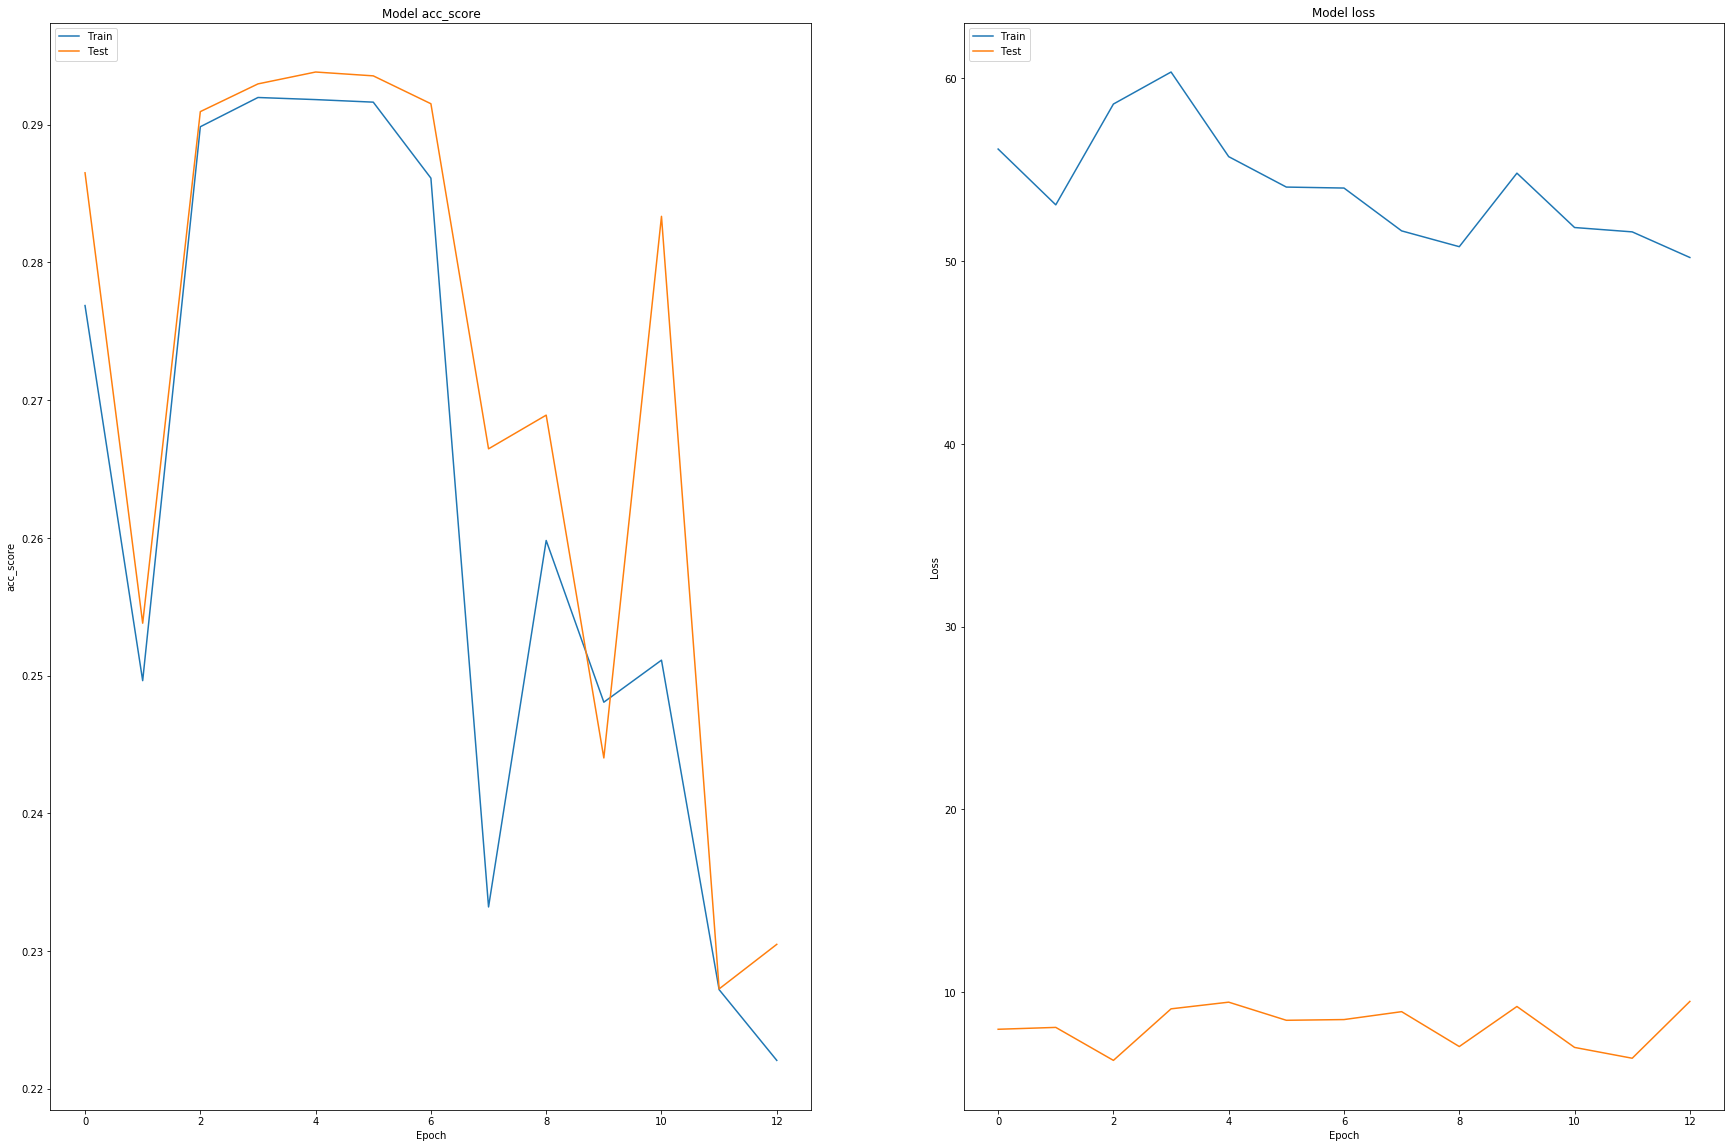

In [13]:
import matplotlib.pyplot as plt
# Plot training & validation iou_score values
plt.figure(figsize=(30, 20))
plt.subplot(121)
plt.plot(history.history['acc_grain'])
plt.plot(history.history['val_acc_grain'])
plt.title('Model acc_score')
plt.ylabel('acc_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [14]:
class FNetLayer(layers.Layer):
    def __init__(self, num_patches, embedding_dim, dropout_rate, *args, **kwargs):
        super(FNetLayer, self).__init__(*args, **kwargs)

        self.ffn = keras.Sequential(
            [
                layers.Dense(units=embedding_dim),
                tfa.layers.GELU(),
                layers.Dropout(rate=dropout_rate),
                layers.Dense(units=embedding_dim),
            ]
        )

        self.normalize1 = layers.LayerNormalization(epsilon=1e-6)
        self.normalize2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        # Apply fourier transformations.
        x = tf.cast(
            tf.signal.fft2d(tf.cast(inputs, dtype=tf.dtypes.complex64)),
            dtype=tf.dtypes.float32,
        )
        # Add skip connection.
        x = x + inputs
        # Apply layer normalization.
        x = self.normalize1(x)
        # Apply Feedfowrad network.
        x_ffn = self.ffn(x)
        # Add skip connection.
        x = x + x_ffn
        # Apply layer normalization.
        return self.normalize2(x)

In [15]:
fnet_blocks = keras.Sequential(
    [FNetLayer(num_patches, embedding_dim, dropout_rate) for _ in range(num_blocks)]
)
learning_rate = 0.001
fnet_classifier = build_classifier(fnet_blocks, positional_encoding=True)
history = run_experiment(fnet_classifier)

Epoch 1/50
300/300 [==============================] - ETA: 0s - loss: 50.8129 - acc_grain: 0.2965
Epoch 00001: val_acc_grain improved from -inf to 0.29904, saving model to checkpoints
300/300 [==============================] - 115s 384ms/step - loss: 50.8129 - acc_grain: 0.2965 - val_loss: 4.3140 - val_acc_grain: 0.2990
Epoch 2/50
300/300 [==============================] - ETA: 0s - loss: 41.8242 - acc_grain: 0.2984
Epoch 00002: val_acc_grain did not improve from 0.29904
300/300 [==============================] - 115s 382ms/step - loss: 41.8242 - acc_grain: 0.2984 - val_loss: 6.1960 - val_acc_grain: 0.2981
Epoch 3/50
300/300 [==============================] - ETA: 0s - loss: 38.4036 - acc_grain: 0.2984
Epoch 00003: val_acc_grain improved from 0.29904 to 0.30025, saving model to checkpoints
300/300 [==============================] - 115s 384ms/step - loss: 38.4036 - acc_grain: 0.2984 - val_loss: 5.7724 - val_acc_grain: 0.3003
Epoch 4/50
300/300 [==============================] - ETA: 0s

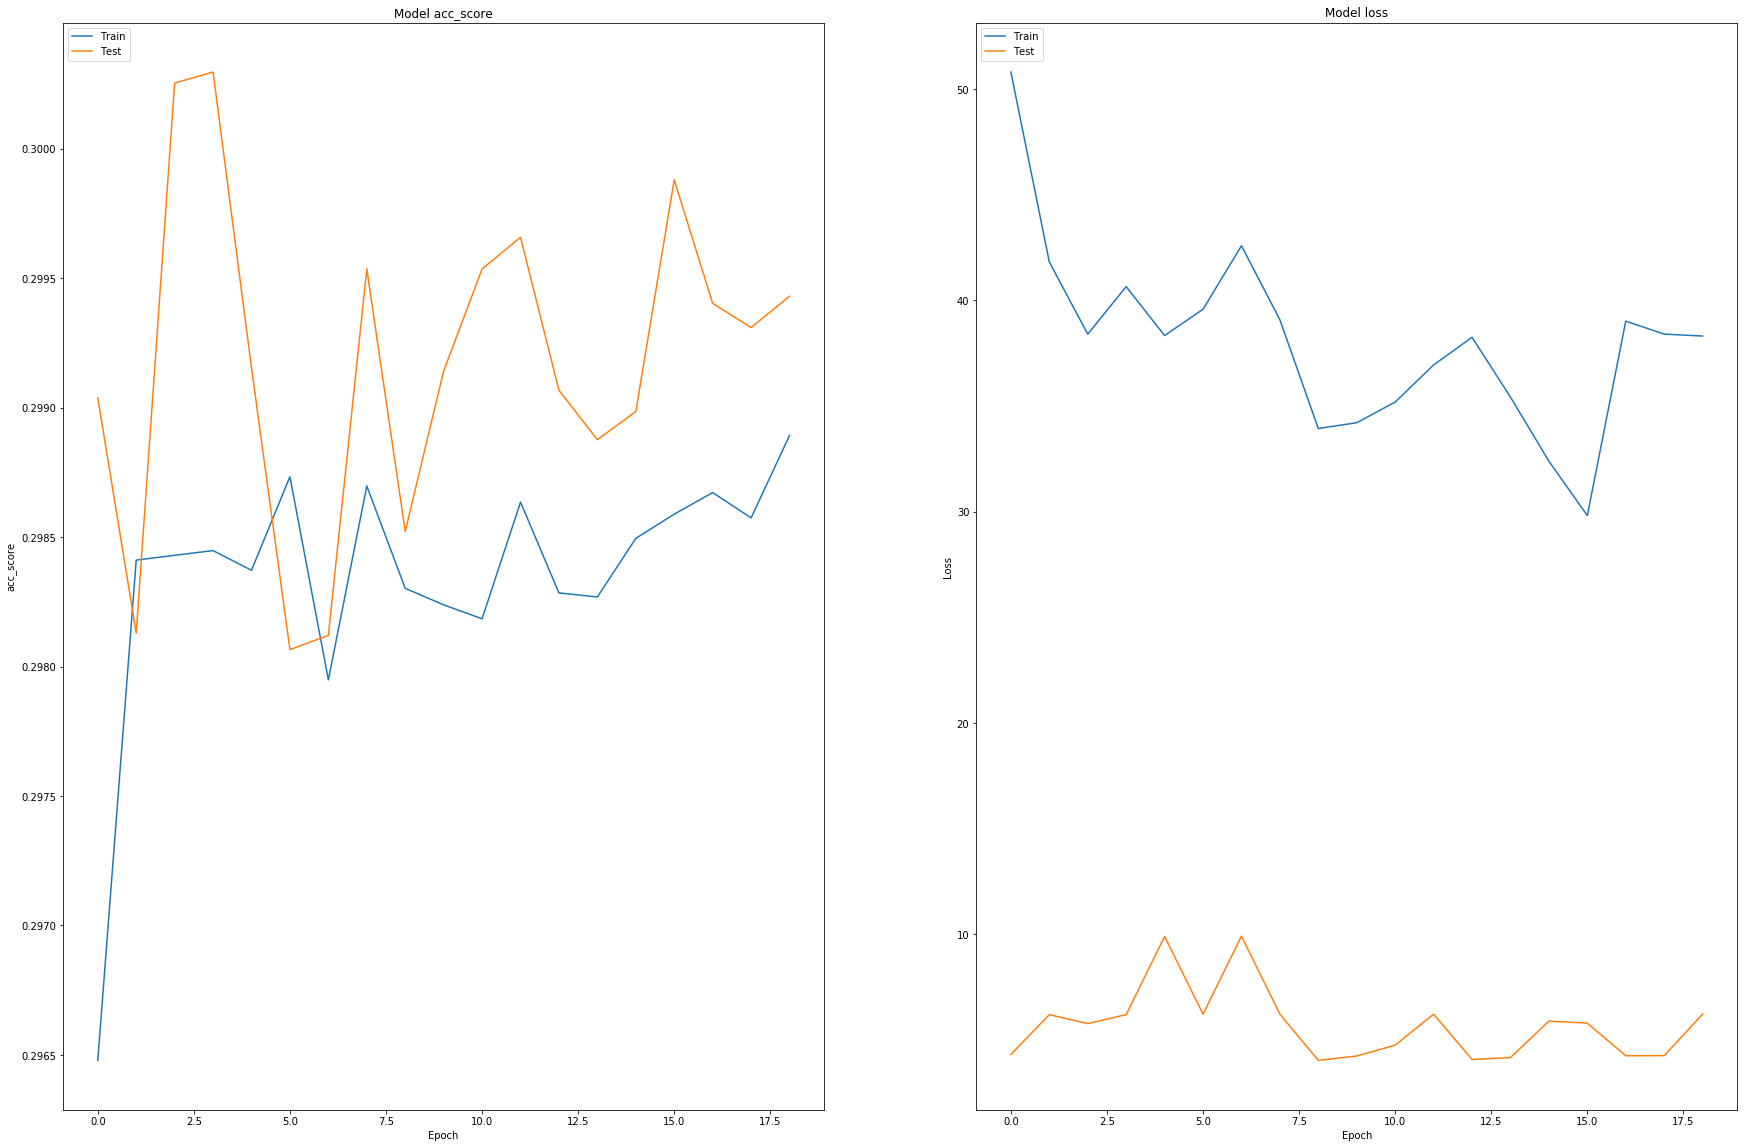

In [16]:
import matplotlib.pyplot as plt
# Plot training & validation iou_score values
plt.figure(figsize=(30, 20))
plt.subplot(121)
plt.plot(history.history['acc_grain'])
plt.plot(history.history['val_acc_grain'])
plt.title('Model acc_score')
plt.ylabel('acc_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [17]:
class gMLPLayer(layers.Layer):
    def __init__(self, num_patches, embedding_dim, dropout_rate, *args, **kwargs):
        super(gMLPLayer, self).__init__(*args, **kwargs)

        self.channel_projection1 = keras.Sequential(
            [
                layers.Dense(units=embedding_dim * 2),
                tfa.layers.GELU(),
                layers.Dropout(rate=dropout_rate),
            ]
        )

        self.channel_projection2 = layers.Dense(units=embedding_dim)

        self.spatial_projection = layers.Dense(
            units=num_patches, bias_initializer="Ones"
        )

        self.normalize1 = layers.LayerNormalization(epsilon=1e-6)
        self.normalize2 = layers.LayerNormalization(epsilon=1e-6)

    def spatial_gating_unit(self, x):
        # Split x along the channel dimensions.
        # Tensors u and v will in th shape of [batch_size, num_patchs, embedding_dim].
        u, v = tf.split(x, num_or_size_splits=2, axis=2)
        # Apply layer normalization.
        v = self.normalize2(v)
        # Apply spatial projection.
        v_channels = tf.linalg.matrix_transpose(v)
        v_projected = self.spatial_projection(v_channels)
        v_projected = tf.linalg.matrix_transpose(v_projected)
        # Apply element-wise multiplication.
        return u * v_projected

    def call(self, inputs):
        # Apply layer normalization.
        x = self.normalize1(inputs)
        # Apply the first channel projection. x_projected shape: [batch_size, num_patches, embedding_dim * 2].
        x_projected = self.channel_projection1(x)
        # Apply the spatial gating unit. x_spatial shape: [batch_size, num_patches, embedding_dim].
        x_spatial = self.spatial_gating_unit(x_projected)
        # Apply the second channel projection. x_projected shape: [batch_size, num_patches, embedding_dim].
        x_projected = self.channel_projection2(x_spatial)
        # Add skip connection.
        return x + x_projected

In [18]:
gmlp_blocks = keras.Sequential(
    [gMLPLayer(num_patches, embedding_dim, dropout_rate) for _ in range(num_blocks)]
)
learning_rate = 0.003
gmlp_classifier = build_classifier(gmlp_blocks)
history = run_experiment(gmlp_classifier)

Epoch 1/50
300/300 [==============================] - ETA: 0s - loss: 52.6064 - acc_grain: 0.0876
Epoch 00001: val_acc_grain improved from -inf to 0.04523, saving model to checkpoints
300/300 [==============================] - 115s 385ms/step - loss: 52.6064 - acc_grain: 0.0876 - val_loss: 6.1096 - val_acc_grain: 0.0452
Epoch 2/50
300/300 [==============================] - ETA: 0s - loss: 46.8402 - acc_grain: 0.1480
Epoch 00002: val_acc_grain did not improve from 0.04523
300/300 [==============================] - 113s 376ms/step - loss: 46.8402 - acc_grain: 0.1480 - val_loss: 10.0085 - val_acc_grain: 0.0022
Epoch 3/50
300/300 [==============================] - ETA: 0s - loss: 42.6871 - acc_grain: 0.1749
Epoch 00003: val_acc_grain improved from 0.04523 to 0.22878, saving model to checkpoints
300/300 [==============================] - 113s 377ms/step - loss: 42.6871 - acc_grain: 0.1749 - val_loss: 6.1096 - val_acc_grain: 0.2288
Epoch 4/50
300/300 [==============================] - ETA: 0

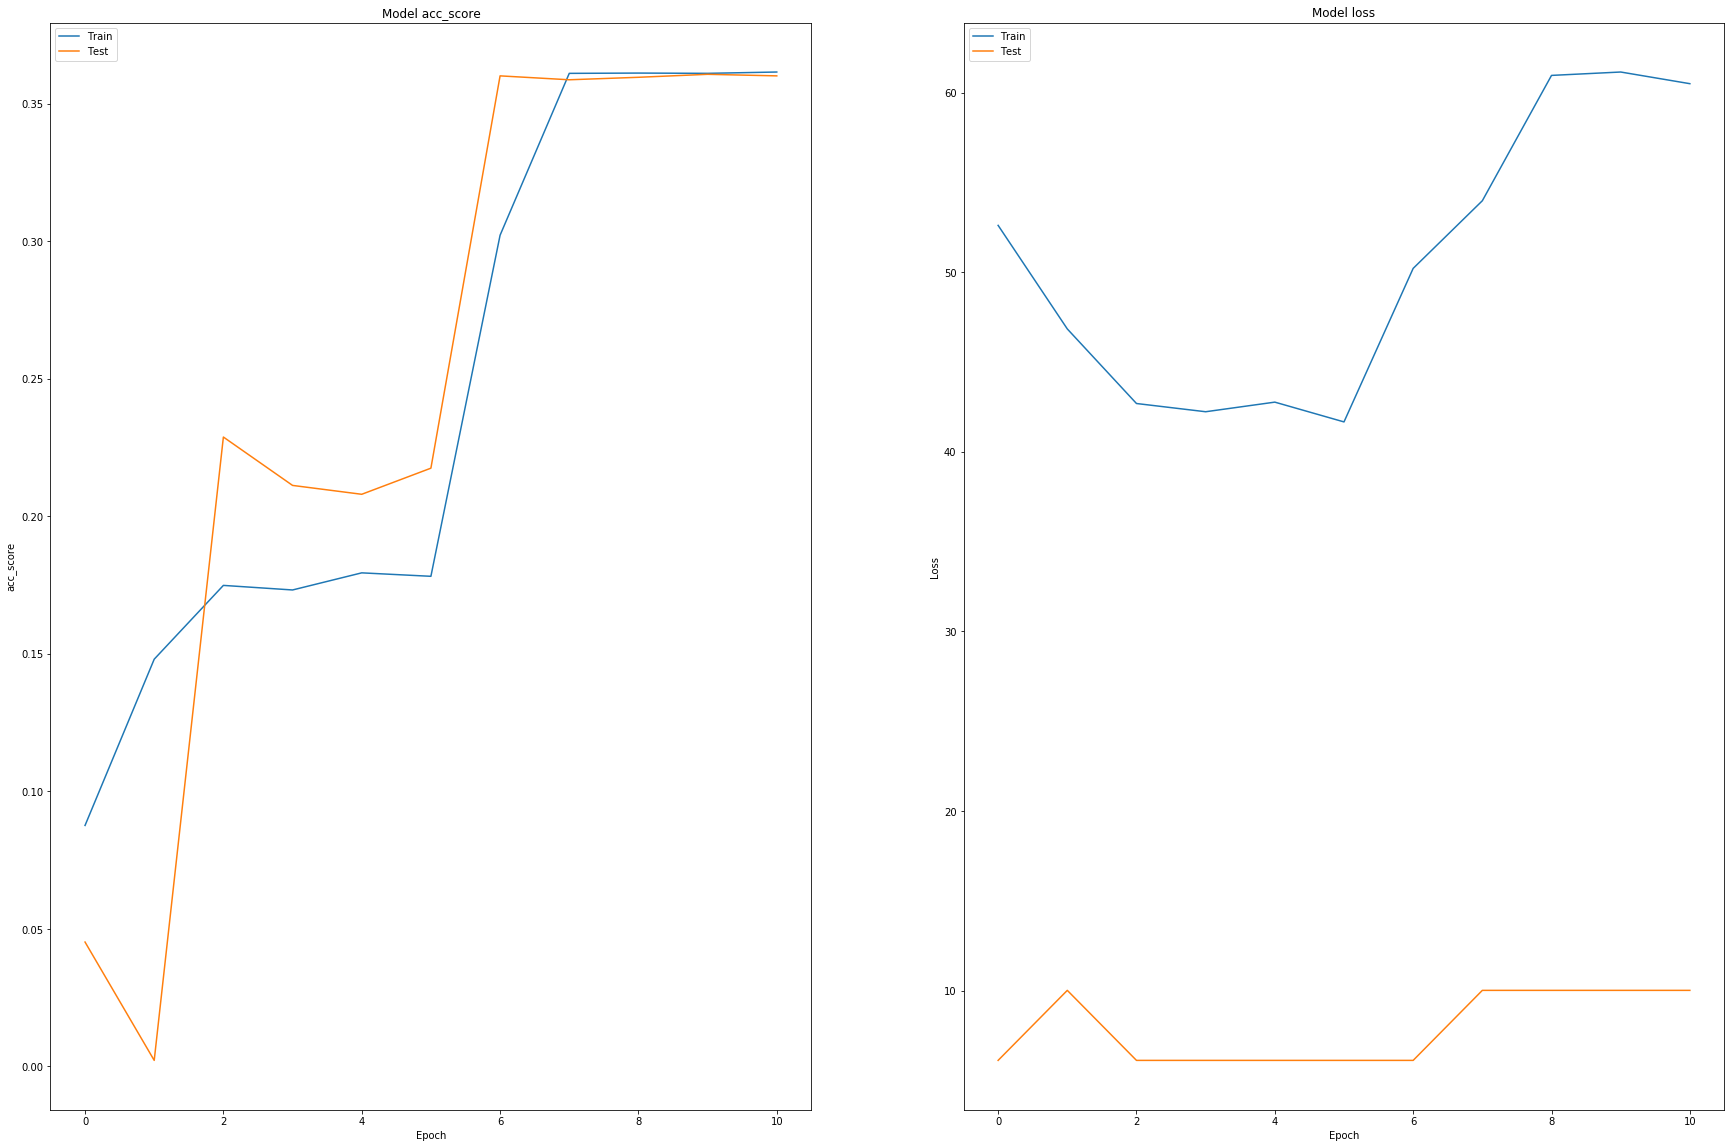

In [19]:
import matplotlib.pyplot as plt
# Plot training & validation iou_score values
plt.figure(figsize=(30, 20))
plt.subplot(121)
plt.plot(history.history['acc_grain'])
plt.plot(history.history['val_acc_grain'])
plt.title('Model acc_score')
plt.ylabel('acc_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
from tensorflow.keras.preprocessing import image
import pandas as pd
import zipfile
import csv

start = time.time()

def load_class_list(class_list_file):
    class_list = []
    with open(class_list_file, 'r') as csvfile:
        file_reader = csv.reader(csvfile)
        for row in file_reader:
            class_list.append(row[0])
    class_list.sort()
    return class_list

class_list = load_class_list('class_list.txt')

IMG_SIZE=224
LBL = dict(zip(class_list, range(28)))

cls_map = dict(zip(LBL.values(),LBL.keys()))

def init_dir(pth):
    if os.path.exists(pth):
        shutil.rmtree(pth)
    os.mkdir(pth)

logger.info("loading the model")
model = model_fn(args['model_dir'])
logger.info("Reading the test set")

res = []
for fn in glob.iglob(args['data_dir'] + 'val/**/*.png', recursive=True):
    file_name = os.path.basename(fn)
    path = os.path.abspath(fn)
    folder = os.path.split(os.path.dirname(path))[1]
    if len(file_name.split("-")) > 2:  # ignore master image with may grains, raw image names are in guid format
        im = image.load_img(path, target_size=(IMG_SIZE, IMG_SIZE))
        img_array = image.img_to_array(im)
        img_batch = np.expand_dims(img_array, axis=0)
        img_preprocessed = preprocess_input(img_batch)
        pred = model.predict(img_preprocessed)
        top3 = (-pred[0]).argsort()[:3]
        res.append({'file_name': file_name, 'path': path, 'cls': folder, 'prediction':top3[0],  'proba_1':pred[0][top3[0]], 'prediction2':top3[1], 'proba_2':pred[0][top3[1]],  'prediction3':top3[2], 'proba_3':pred[0][top3[2]]})

df = pd.DataFrame(res)
df['prediction'] = df.prediction.map(cls_map)
df['prediction2'] = df.prediction2.map(cls_map)
df['prediction3'] = df.prediction3.map(cls_map)

from sklearn.metrics import accuracy_score

def w(x):
    if "_SOUND" in x:
        return 8.94 # weighting  Healthy grains more important than defective grains
    return 1

def scoring_fn(df):
    """
    Weighted Accuracy Metric 90% Healthy grains, 10% unhealthy grains
    """
    df['weight'] = df.cls.apply(w)
    return accuracy_score(df.cls,df.prediction,sample_weight=df.weight)

logger.info(f"predictions have shape of {df.shape}")

score = scoring_fn(df)
print ("Accuracy Score:" + str(score))
# write to the output location

print('Duration Run',(time.time()-start)/3600,' hours')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(df['cls'], df['prediction']))

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
ticks=np.linspace(0, 27,num=28)
plt.figure(figsize=(15,15))
plt.imshow(confusion_matrix(df['cls'], df['prediction'],normalize='true'), interpolation='none')
plt.colorbar()
plt.xticks(ticks,fontsize=6)
plt.yticks(ticks,fontsize=6)
plt.grid(True)
plt.show()

In [ ]:
from keras_preprocessing import image

In [ ]:
NUM_CLASSES=28
model = build_model(num_classes=NUM_CLASSES)
model.fit?

In [ ]:
image.random_rotation(90)

In [ ]:
 rotation_range=args.rotation,
      shear_range=args.shear,
      zoom_range=args.zoom,
      horizontal_flip=args.h_flip,
      vertical_flip=args.v_flip